In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybaseball import *
sys.path.append('/home/dcooper/rockies/RockiesAnalysis/')
from utils.plotting.pitch_movement_plot import plot_pitcher_home_away_movement
from utils.analysis.savant import get_pitcher_home_away_movement, filter_df
from utils.scraping.safe_playerid_lookup import fangraphs_playerid_lookup
from utils.scraping.fangraphs import get_player_fangraphs_props, is_pitcher
from utils.scraping.split_name import split_name
from datetime import date
today = date.today().strftime("%Y-%m-%d")

import warnings
warnings.filterwarnings('ignore')

/home/dcooper/anaconda3/envs/rockies/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Load pitchers

In [2]:
# Load roster
from utils.scraping.rosters import scrape_roster
MLB_roster = scrape_roster(level='MLB')

In [3]:
# outs = [
#     'field_out', 
#     'strikeout', 
#     'grounded_into_double_play', 
#     'force_out', 
#     'sac_fly', 
#     'sac_bunt', 
#     'fielders_choice_out', 
#     'fielders_choice', 
#     'double_play', 
#     'strikeout_double_play', 
#     'sac_fly_double_play'
# ]

# AB_events = [
#     'field_out',
#     'strikeout',
#     'single',
#     'grounded_into_double_play',
#     'double',
#     'home_run',
#     'force_out',
#     'triple',
#     'field_error',
#     'fielders_choice_out',
#     'fielders_choice',
#     'double_play',
#     'strikeout_double_play',
#     'triple_play'
# ]

# def get_ABs(df):
#     df = df.loc[~df['events'].isnull()]
#     return df[df['events'].isin(AB_events)].shape[0]

# def get_SLG(df):
#     singles = filter_df(df, events='single').shape[0]
#     doubles = filter_df(df, events='double').shape[0]
#     triples = filter_df(df, events='triple').shape[0]
#     home_runs = filter_df(df, events='home_run').shape[0]

#     try:
#         return (1*singles + 2*doubles + 3*triples + 4*home_runs) / get_ABs(df)
#     except ZeroDivisionError:
#         return 0


In [4]:
# def get_pitcher_home_away_movement(pitcher_df):
#     """
#     Get per-pitch movement splits, assumes pitcher_df is only 1 pitcher
#     """
    
#     # Get pitchs (skipping nan)
#     pitches = [str(pitch) for pitch in pitcher_df['pitch_type'].unique() if str(pitch) not in ['nan', 'PO']]

#     # Initialize pitch splits dataframe
#     # pitch_split_df = pd.DataFrame(columns=['Home X Break', 'Home Y Break', 'Away X Break', 'Away Y Break', 'ΔX Break', 'ΔY Break', 'ΔBreak', '%Change', 'Home Usage', 'Away Usage'])
#     pitch_split_df = pd.DataFrame(columns=['ΔBreak', '%Change', 'Home Usage', 'Away Usage', 'Home SLG', 'Away SLG'])

    
#     # Iterate through pitches
#     from scipy.spatial.distance import euclidean
#     h_xy = []
#     aw_xy = []
#     for i, pitch in enumerate(pitches):

#         # Away
#         away_pitch_df = filter_df(pitcher_df, away_team='COL', pitch_type=pitch)
#         awx, awy = -away_pitch_df['pfx_x']*12, away_pitch_df['pfx_z']*12
#         away_usage = away_pitch_df.shape[0] / filter_df(pitcher_df, away_team='COL').shape[0]

#         # Home
#         home_pitch_df = filter_df(pitcher_df, home_team='COL', pitch_type=pitch)
#         hx, hy = -home_pitch_df['pfx_x']*12, home_pitch_df['pfx_z']*12
#         home_usage = home_pitch_df.shape[0] / filter_df(pitcher_df, home_team='COL').shape[0]
        
#         # Deltas 
#         delta_x = -1 * np.abs(hx.mean(axis=0) - awx.mean(axis=0))
#         delta_y = -1 * np.abs(hy.mean(axis=0) - awy.mean(axis=0))
#         home_break = math.hypot(hx.mean(), hy.mean())
#         away_break = math.hypot(awx.mean(), awy.mean())
#         delta_break = home_break - away_break
#         percent_change = 100 * delta_break / away_break

#         # Get SLG
#         away_SLG = get_SLG(away_pitch_df)
#         home_SLG = get_SLG(home_pitch_df)

#         # Add to dataframe
#         pitch_split_df.loc[pitch_full_names[pitch]] = [delta_break, percent_change, home_usage, away_usage, home_SLG, away_SLG]
#         # pitch_split_df.loc[pitch_full_names[pitch]] = [hx.mean(), hy.mean(), awx.mean(), awy.mean(), delta_x, delta_y, delta_break, percent_change, home_usage, away_usage]

#         # Add to lists 
#         h_xy.append([hx, hy])
#         aw_xy.append([awx, awy])

#     return pitch_split_df, h_xy, aw_xy

In [5]:
# import os, sys, json
# import matplotlib.pyplot as plt
# from matplotlib.colors import to_rgba
# from matplotlib.table import Table
# from matplotlib.patches import Circle
# import numpy as np
# sys.path.append('/home/dcooper/rockies/RockiesAnalysis')
# # from utils.analysis.savant import get_pitcher_home_away_movement, filter_df

# pitch_full_names = json.load(open('/home/dcooper/rockies/RockiesAnalysis/utils/analysis/savant_pitch_names.json', 'r'))
# pitch_colors = json.load(open('/home/dcooper/rockies/RockiesAnalysis/utils/analysis/savant_pitch_colors.json', 'r'))

# def confidence_ellipse_params(x, y, n_std=1.25):
#     """
#     Returns ellipse parameters (width, height, angle, center)
#     for a 2D confidence ellipse.
#     """
#     cov = np.cov(x, y)
#     mean_x, mean_y = np.mean(x), np.mean(y)

#     # Eigen decomposition
#     eigenvals, eigenvecs = np.linalg.eigh(cov)

#     # Sort largest → smallest
#     order = eigenvals.argsort()[::-1]
#     eigenvals = eigenvals[order]
#     eigenvecs = eigenvecs[:, order]

#     # Width and height of ellipse
#     width = 2 * n_std * np.sqrt(eigenvals[0])
#     height = 2 * n_std * np.sqrt(eigenvals[1])

#     # Angle in degrees
#     angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

#     return mean_x, mean_y, width, height, angle

# from matplotlib.patches import Ellipse
# def plot_pitch_ellipse(ax, x, y, facecolor, edgecolor, hatch=None, label=None, n_std=1.25, zorder=None):
#     cx, cy, w, h, angle = confidence_ellipse_params(x, y, n_std)

#     ellipse = Ellipse(
#         (cx, cy),
#         width=w,
#         height=h,
#         angle=angle,
#         facecolor=facecolor,
#         alpha=0.5,
#         edgecolor=edgecolor,
#         lw=2,
#         label=label,
#         hatch=hatch,
#         zorder=zorder
#     )

#     ax.add_patch(ellipse)
#     ax.scatter(cx, cy, s=12, color=edgecolor)


# def plot_base(figsize=(6,6)):
#     fig, ax = plt.subplots(figsize=figsize)

#     # Plot cross hairs
#     ax.vlines(0, -24 ,24, color='k', alpha=0.15)
#     ax.hlines(0, -24 ,24, color='k', alpha=0.15)

#     # Plot circles
#     from matplotlib.patches import Circle
#     circle_r = np.array([6, 12, 18, 24])
#     circle_ls = np.array(['dashed', 'solid', 'dashed', 'solid'])
#     for r, ls in zip(circle_r, circle_ls):
#         circle = Circle((0,0), radius=r, facecolor='none', edgecolor='black', lw=1, linestyle=ls, alpha=0.15)
#         ax.add_patch(circle)

#     # Add labels
#     ax.text(-7, -2,'6"', color='grey')
#     ax.text(-13, -2,'12"', color='grey')
#     ax.text(-19, -2,'18"', color='grey')
#     ax.text(-25, -2,'24"', color='grey')
#     ax.text(11, -2,'12"', color='grey')
#     ax.text(23, -2,'24"', color='grey')
#     ax.text(1, 11,'12"', color='grey')
#     ax.text(1, 23,'24"', color='grey')
#     ax.text(1, -11,'12"', color='grey')
#     ax.text(1, -23,'24"', color='grey')

#     return fig, ax

# def _add_home_away_table(fig, ax):
#     """
#     Home/Away hatch table
#     """
#     # Initalize table
#     from matplotlib.table import Table
#     ax_table = fig.add_axes([0.675,0.3,0.17,0.08])
#     ax_table.axis('off')
#     table = Table(ax_table, bbox=[1,1,1,1])

#     # Home
#     cell = table.add_cell(0,0,width=0.1, height=0.1, facecolor=to_rgba('black', 0.15), edgecolor='black')
#     cell.visible_edges = 'closed'
#     cell = table.add_cell(0,1,width=0.15, height=0.1, text='Home')
#     cell.visible_edges = 'open'

#     # Away
#     cell = table.add_cell(1,0,width=0.1, height=0.1, facecolor='white', edgecolor='black')
#     cell.set_hatch('///')
#     cell.visible_edges = 'closed'
#     cell = table.add_cell(1,1,width=0.15, height=0.1, text='Away')
#     cell.visible_edges = 'open'

#     # Set font and add
#     table.auto_set_font_size(False)
#     table.set_fontsize(9)
#     ax_table.add_table(table)

#     return fig, ax

# def _add_pitch_type_table(fig, ax):
#     """
#     Pitch types table
#     """
#     # Initialize table
#     ax_table = fig.add_axes([0.2,0.35,0.8,0.3])
#     ax_table.axis('off')
#     table = Table(ax_table, bbox=[1,1,1,1])
    
#     # Add headers
#     cell = table.add_cell(0,1,width=0.7, height=1, text='Pitch')
#     cell.visible_edges = 'B'
#     cell.get_text().set_ha("center")
#     cell = table.add_cell(0,2,width=0.4, height=2, text='ΔBreak\n(in)')
#     cell.visible_edges = 'B'
#     cell.get_text().set_ha("center")
#     cell = table.add_cell(0,3,width=0.4, height=2, text='%Change')
#     cell.visible_edges = 'B'
#     cell.get_text().set_ha("center")
#     cell = table.add_cell(0,4,width=0.6, height=2, text='Usage\n(Home : Away)')
#     cell.visible_edges = 'B'
#     cell.get_text().set_ha("center")
#     cell = table.add_cell(0,5,width=0.7, height=2, text='SLG\n(Home : Away)')
#     cell.visible_edges = 'B'
#     cell.get_text().set_ha("center")

#     return fig, ax, ax_table, table

# def plot_pitcher_home_away_movement(last, first, year=2025, show: bool=True):
#     """
#     Plot pitcher home v away movement from savant
#     """

#     # Get playerid
#     from utils.scraping.safe_playerid_lookup import savant_playerid_lookup
#     playerid = savant_playerid_lookup(last, first)

#     # Get pitch data from season
#     from utils.scraping.savant import load_pitch_data
#     pitch_data = load_pitch_data(year, year)

#     # Get pitch data for player
#     # from utils.analysis.savant import filter_df
#     pitcher_df = filter_df(pitch_data, playerid=playerid, pitcher=True, pitcher_on_team='COL')

#     # Get pitch split info 
#     pitch_split_df, h_xy, aw_xy = get_pitcher_home_away_movement(pitcher_df)
    
#     # Plot base 
#     fig, ax = plot_base()

#     # Add tables
#     fig, ax = _add_home_away_table(fig, ax)
#     fig, ax, ax_pitch_table, pitch_table = _add_pitch_type_table(fig, ax) 

#     # Iterate through pitchers
#     from matplotlib.colors import to_rgba
#     for i, ((pitch, r), (phx, phy), (pawx, pawy)) in enumerate(zip(pitch_split_df.iterrows(), h_xy, aw_xy)):

#         # Plot elipses 
#         plot_pitch_ellipse(ax, pawx, pawy, facecolor='white', edgecolor=to_rgba(pitch_colors[pitch]), hatch='///', zorder=10)
#         plot_pitch_ellipse(ax, phx, phy, facecolor=to_rgba(pitch_colors[pitch]), edgecolor=to_rgba(pitch_colors[pitch]), zorder=20)

#         # Add to legend table
#         cell = pitch_table.add_cell(i+1, 0, width=0.2, height=2, facecolor=(to_rgba(pitch_colors[pitch]), 0.5), edgecolor=to_rgba(pitch_colors[pitch]))
#         cell.visible_edges = 'closed'
#         cell = pitch_table.add_cell(i+1, 1, width=0.7, height=2, text=pitch)
#         cell.visible_edges = 'open'
#         cell.get_text().set_ha("center")
#         cell = pitch_table.add_cell(i+1, 2, width=0.4, height=2, text=f'{-r['ΔBreak']:.1f}')
#         cell.visible_edges = 'open'
#         cell.get_text().set_ha("center")
#         cell = pitch_table.add_cell(i+1, 3, width=0.4, height=2, text=f'{-r['%Change']:.1f}')
#         cell.visible_edges = 'open'
#         cell.get_text().set_ha("center")
#         cell = pitch_table.add_cell(i+1, 4, width=0.6, height=2, text=f'{100*r['Home Usage']:.0f}% : {100*r['Away Usage']:.0f}%')
#         cell.visible_edges = 'open'
#         cell.get_text().set_ha("center")
#         cell = pitch_table.add_cell(i+1, 5, width=0.7, height=2, text=f'{r['Home SLG']:.3f}'.lstrip('0') + ' : ' + f'{r['Away SLG']:.3f}'.lstrip('0'))
#         cell.visible_edges = 'open'
#         cell.get_text().set_ha("center")

#     # Finish table
#     pitch_table.auto_set_font_size(False)
#     pitch_table.set_fontsize(9)
#     ax_pitch_table.add_table(pitch_table)

#     # Set limits
#     ax.set_xlim(-30, 30)
#     ax.set_ylim(-30, 30)
#     ax.set_aspect("equal")
    
#     # Turn ticks off
#     ax.set_xticks([], [])
#     ax.set_yticks([], [])
    
#     # Title
#     ax.set_title(f'{first} {last} {year}\nMovement Profile Home/Road')
    
#     # Convert into circle
#     clip_circle = Circle(
#         (0, 0),        # center
#         radius=25,     # match axis limits
#         transform=ax.transData
#     )
#     for artist in ax.get_children():
#         artist.set_clip_path(clip_circle)

#     # Show, if specified
#     if show:
#         plt.show()
    
#     return fig, ax, pitch_split_df

    

Gathering player lookup table. This may take a moment.


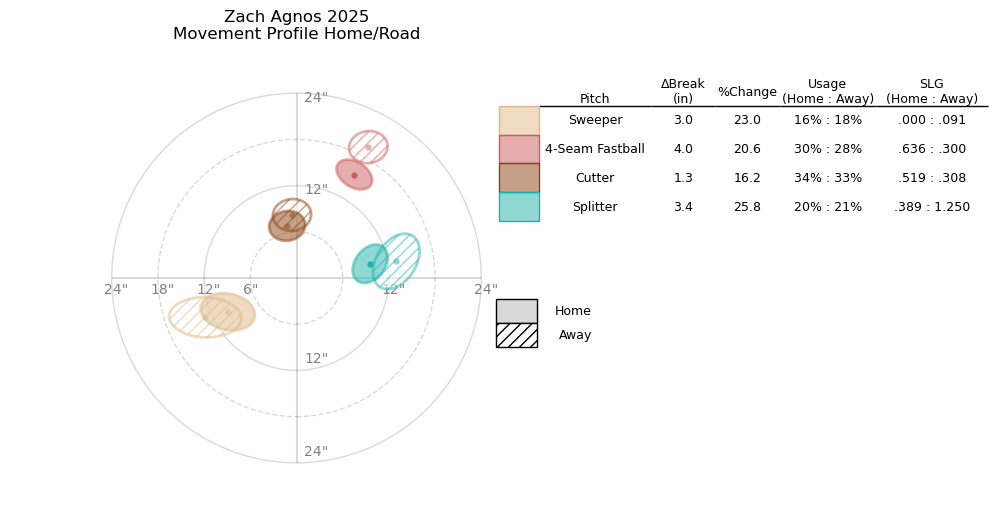

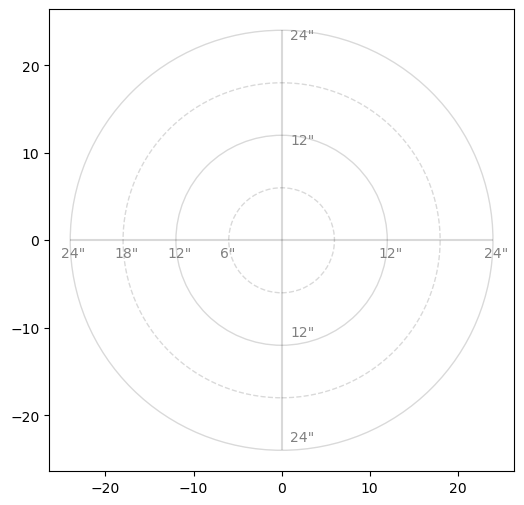

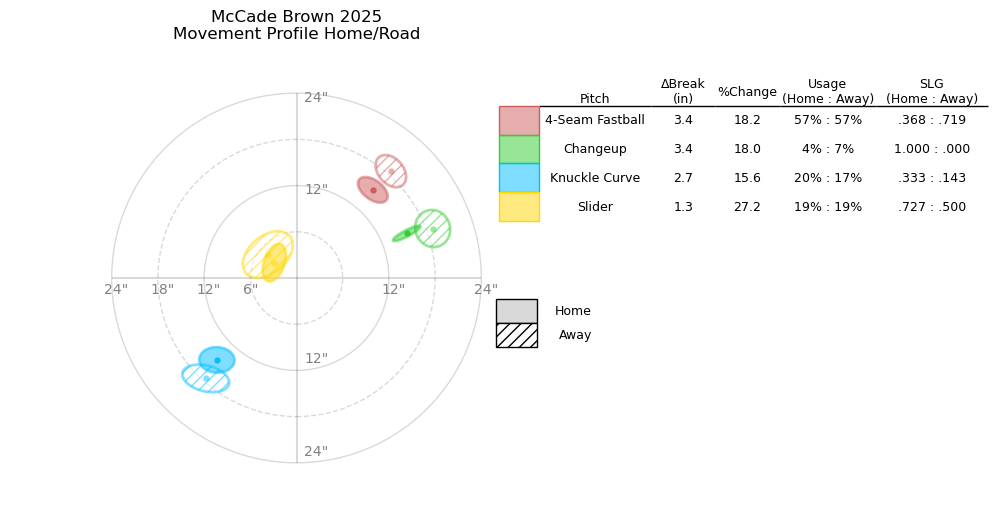

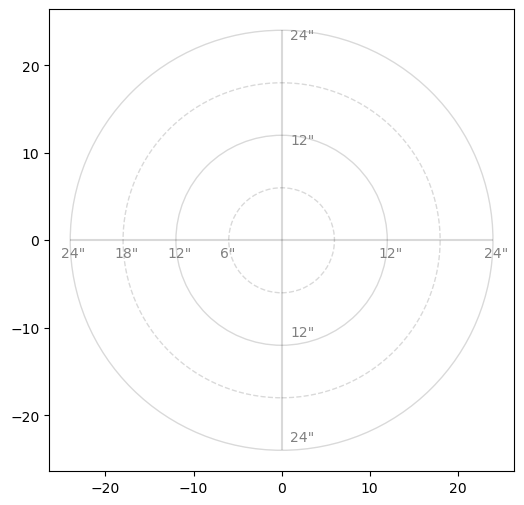

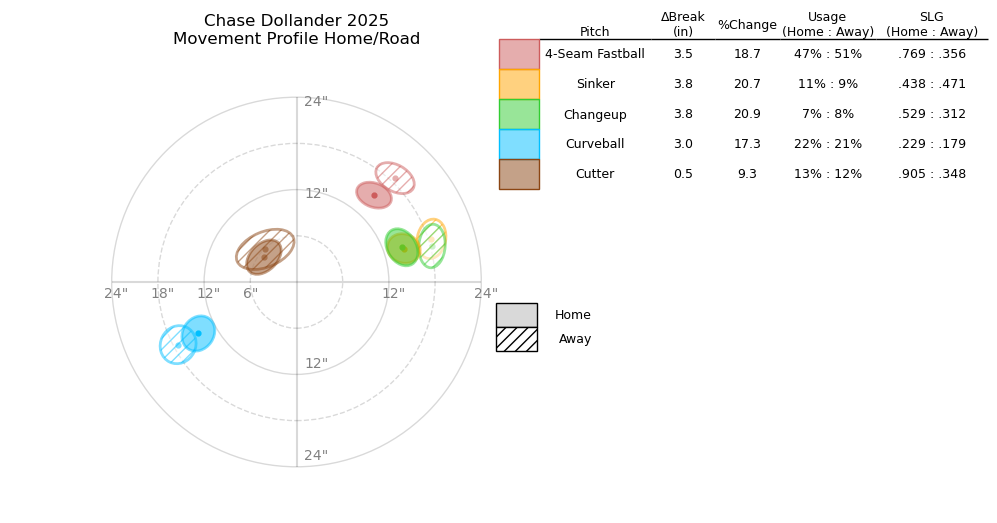

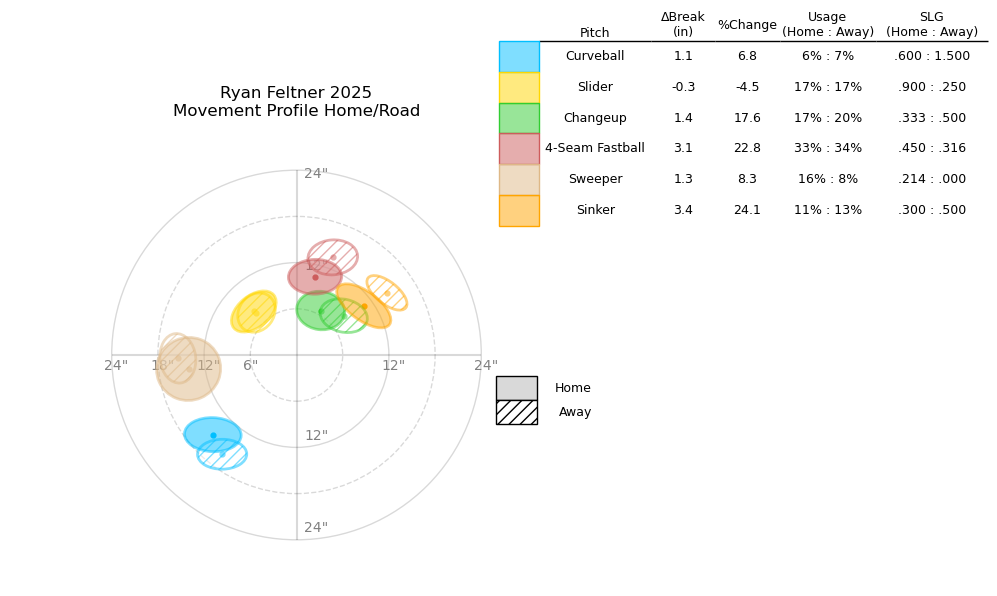

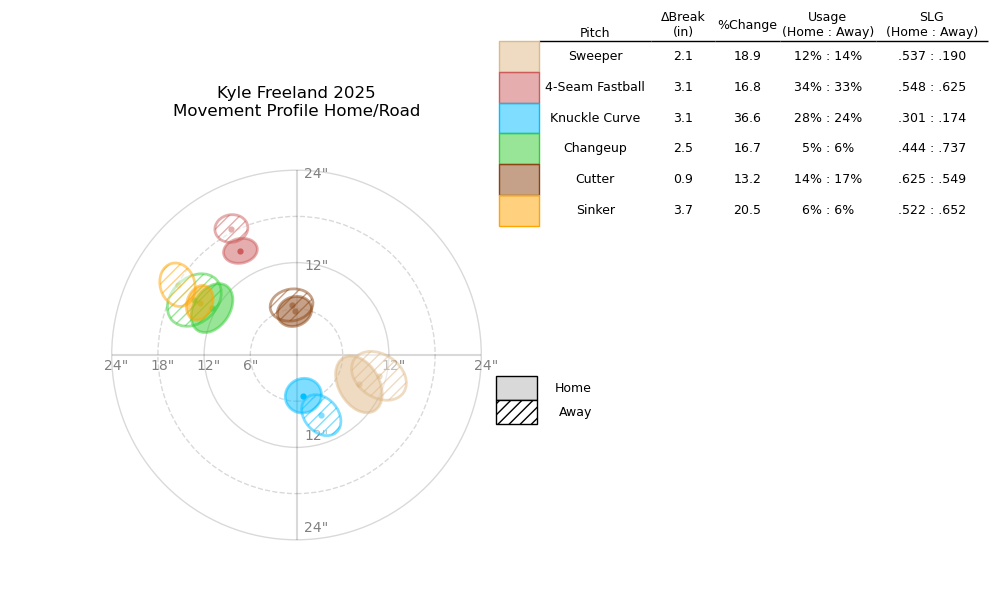

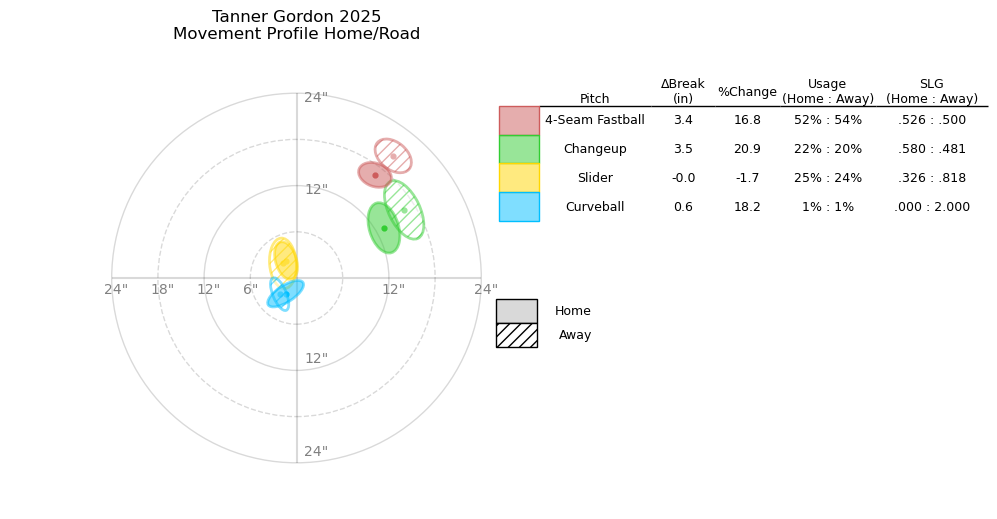

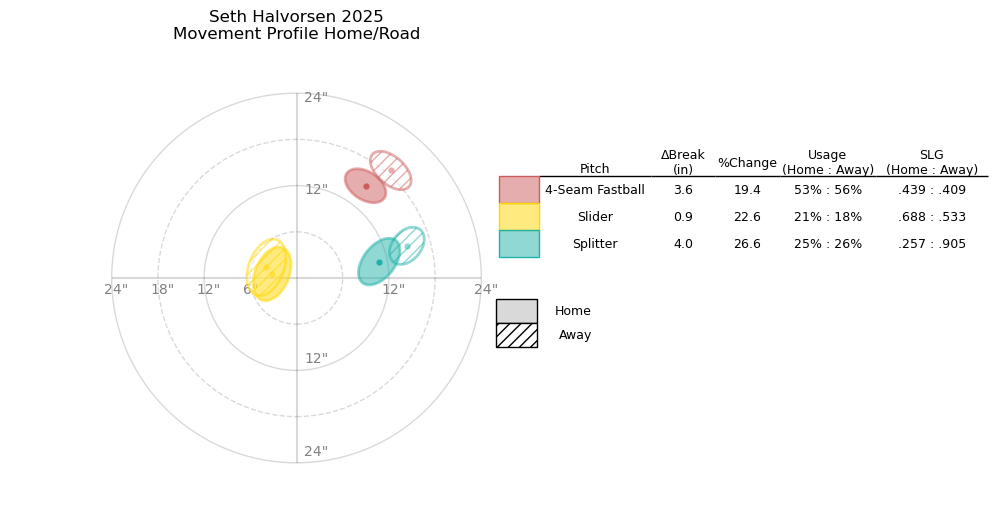

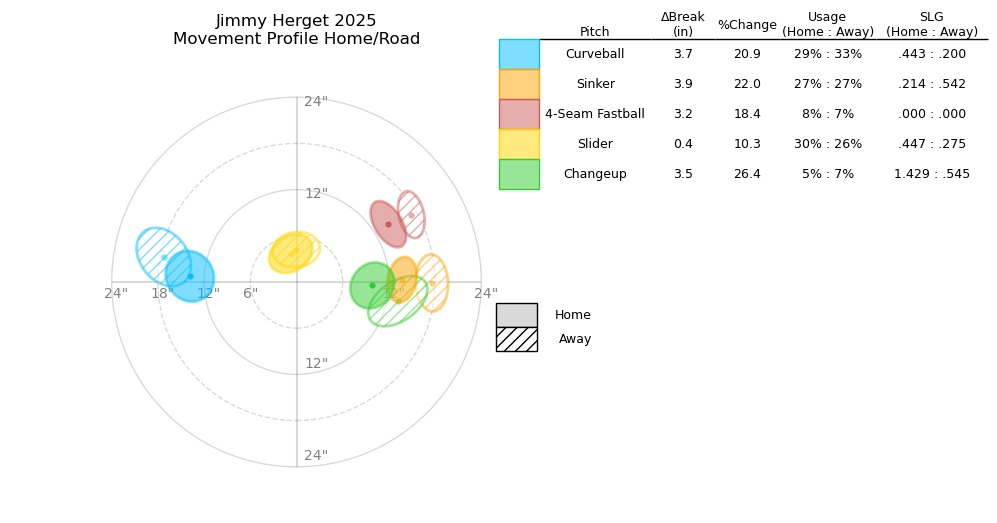

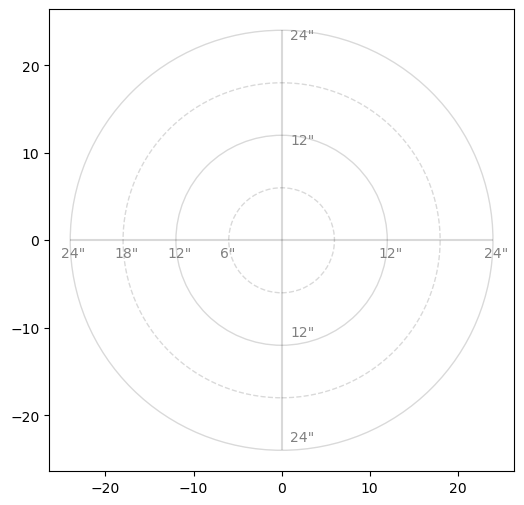

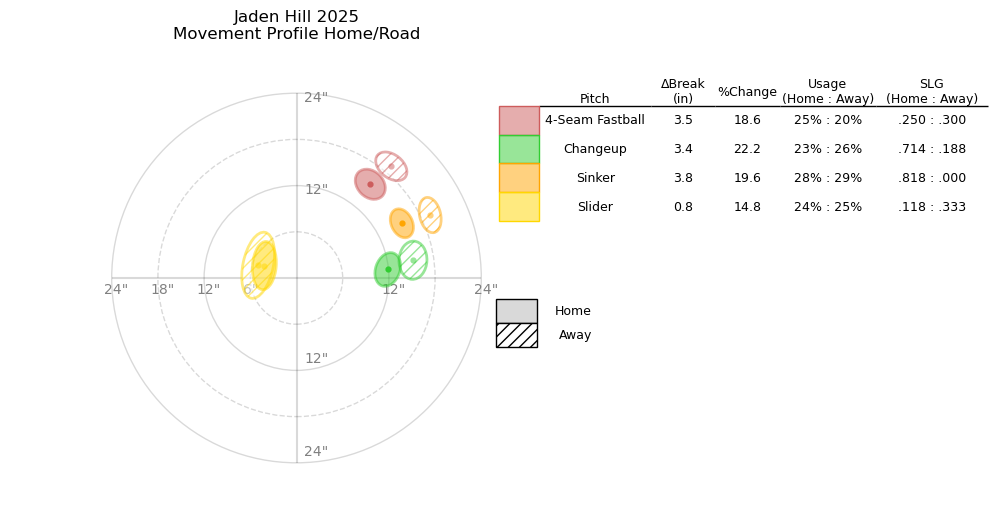

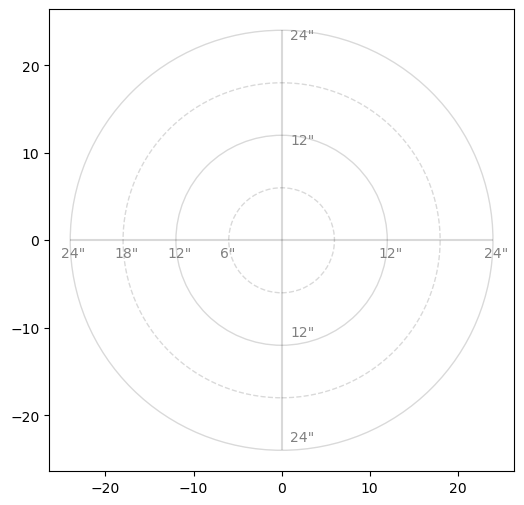

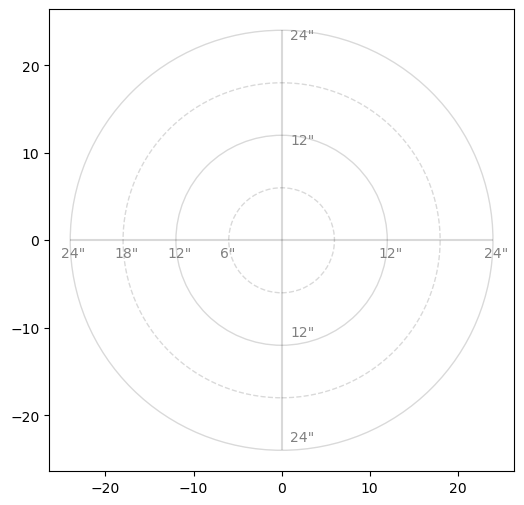

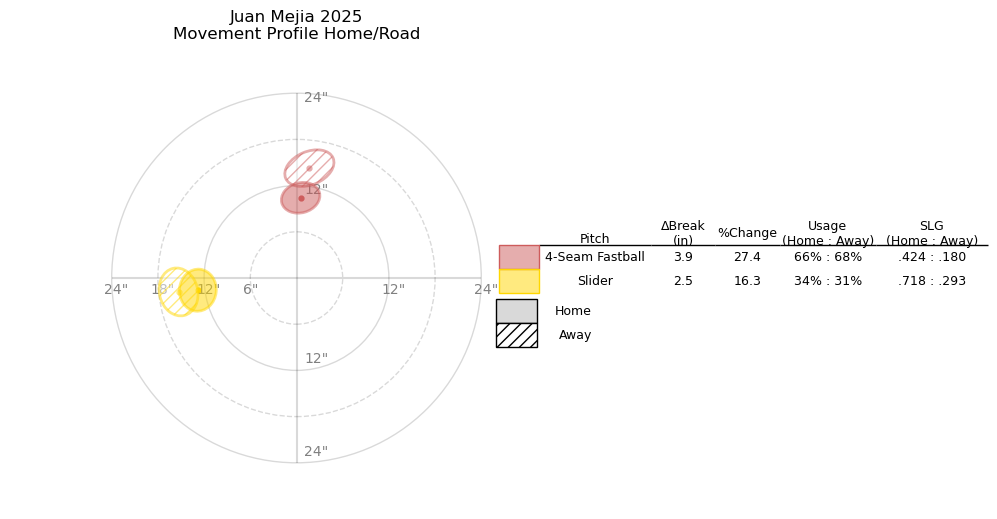

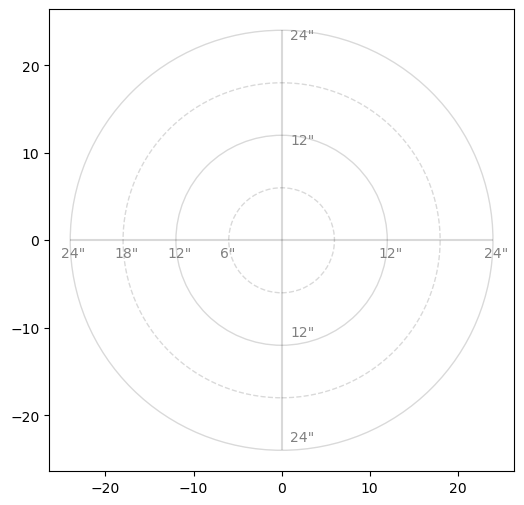

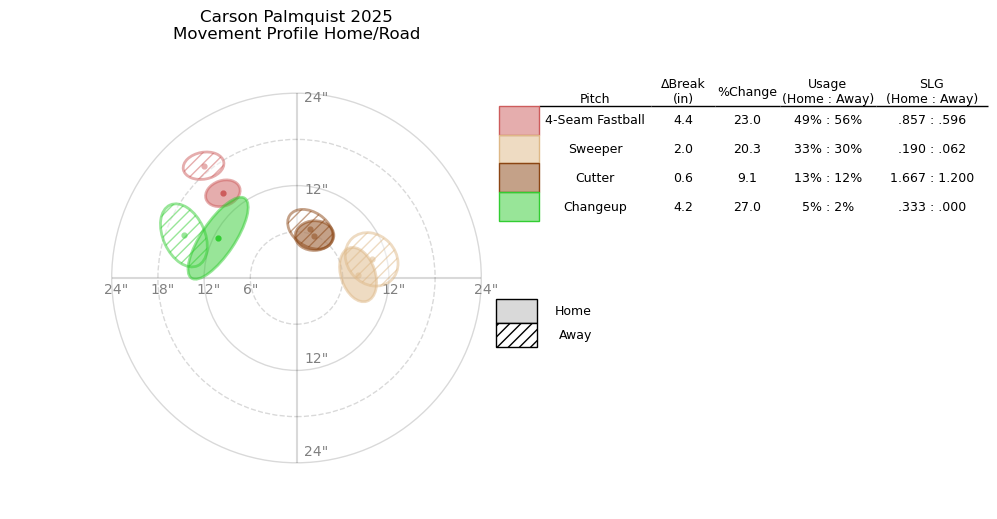

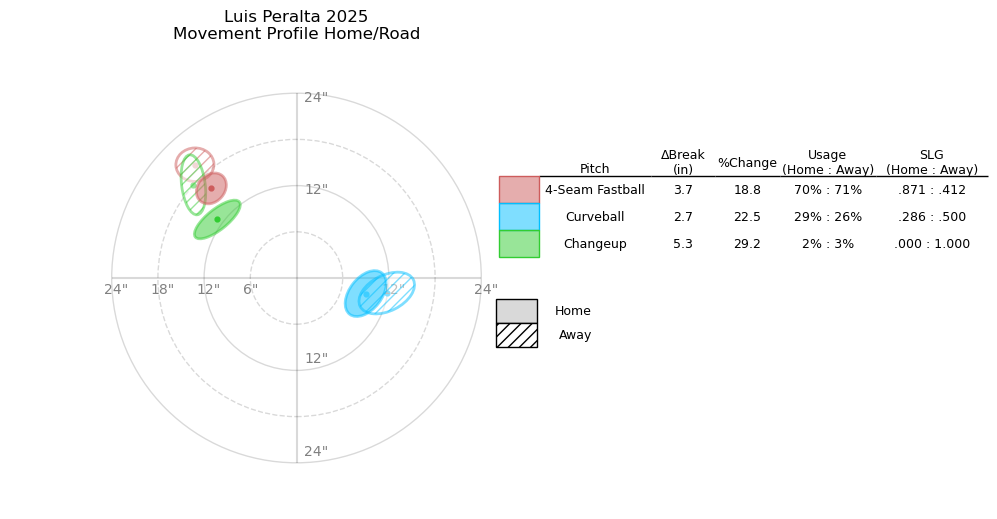

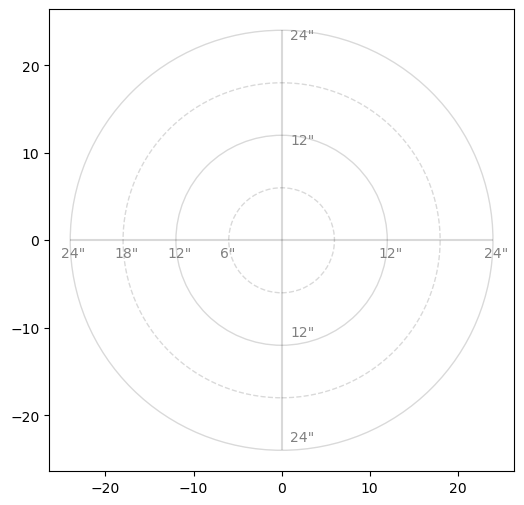

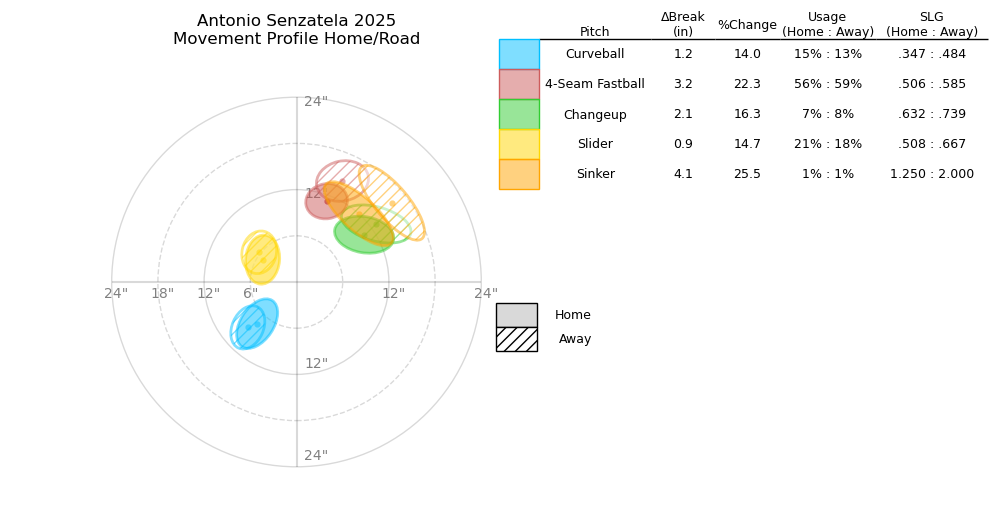

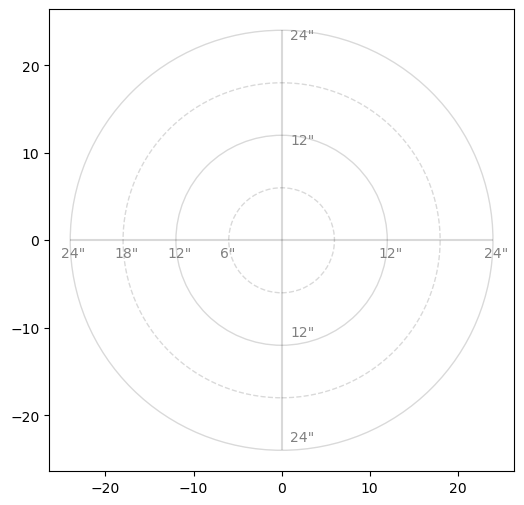

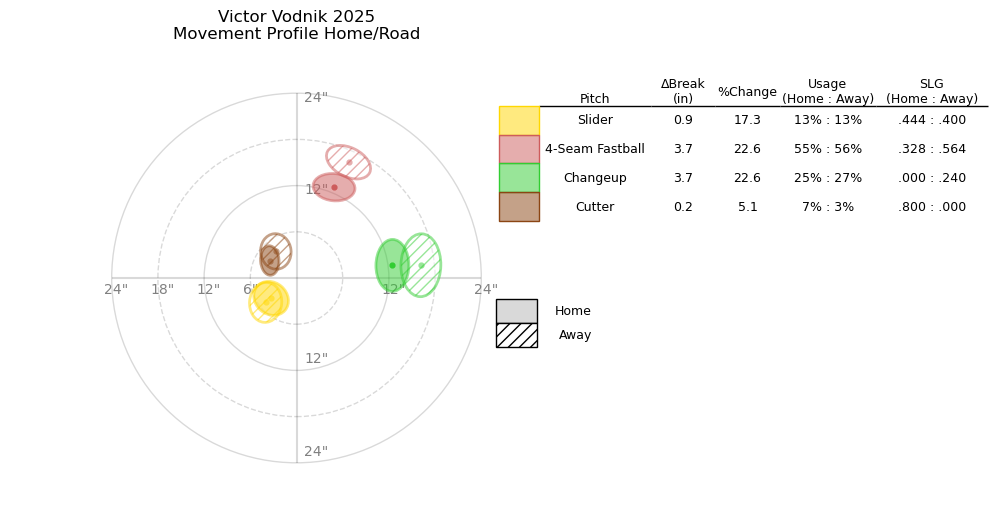

In [6]:
# Figure out who are pitchers
fig_dir = f'./{today}'
os.makedirs(fig_dir, exist_ok=True)
pitch_movement_df = pd.DataFrame(index=pd.MultiIndex(levels=[[],[]], codes=[[],[]], names=['Player', 'Pitch']), 
                                 # columns=['Home X Break (in)', 'Home Y Break (in)', 'Away X Break (in)', 'Away Y Break (in)', 'ΔX Break (in)', 'ΔY Break (in)', 'ΔBreak (in)', '%Change', 'Home Usage', 'Away Usage'])
                                 columns=['ΔBreak (in)', '%Change', 'Home Usage', 'Away Usage', 'Home SLG', 'Away SLG'])
for i, name in enumerate(MLB_roster):
    
    player_props = get_player_fangraphs_props(*split_name(name), playerid=fangraphs_playerid_lookup(*split_name(name)))
    if is_pitcher(player_props):
        fig, ax, player_df = plot_pitcher_home_away_movement(*split_name(name))
        if player_df.shape[0] > 0:
            fig.savefig(os.path.join(fig_dir, name + '.png'), bbox_inches='tight')
        
        # Add to master df
        for pitch, r in player_df.iterrows():
            pitch_movement_df.loc[(name, pitch), :] = r.values



## Summary Table

In [7]:
'ΔBreak', '%Change', 'Home Usage', 'Away Usage', 'Home SLG', 'Away SLG'

('ΔBreak', '%Change', 'Home Usage', 'Away Usage', 'Home SLG', 'Away SLG')

In [18]:
slg_cols = ["Home SLG", "Away SLG"]

slg_gmap = (
    pitch_movement_df[slg_cols]
    .apply(lambda s: s - 0.404)
)

styled = (
    pitch_movement_df.sort_values('%Change').style.format({
    "ΔBreak (in)": "{:+.1f}",
    "%Change": "{:.1%}",
    "Home Usage": "{:.1%}",
    "Away Usage": "{:.1%}",
    "Home SLG": "{:.3f}",
    "Away SLG": "{:.3f}"
    }).background_gradient(
        cmap="bwr",
        subset=["ΔBreak (in)", "%Change", "Home Usage", "Away Usage"],
        
    ).background_gradient(
        cmap="bwr",
        subset=["Home SLG", "Away SLG"],
        vmin=0,
        vmax=0.8
    )
)
styled.to_html(os.path.join(fig_dir, 'summary.html'))
styled

,,ΔBreak (in),%Change,Home Usage,Away Usage,Home SLG,Away SLG
Player,Pitch,,,,,,
Kyle Freeland,Knuckle Curve,-3.1,-36.6%,28.3%,24.1%,0.301,0.174
Luis Peralta,Changeup,-5.3,-29.2%,1.5%,3.0%,0.000,1.000
Juan Mejia,4-Seam Fastball,-3.9,-27.4%,65.7%,68.3%,0.424,0.180
McCade Brown,Slider,-1.3,-27.2%,19.2%,19.4%,0.727,0.500
Carson Palmquist,Changeup,-4.2,-27.0%,5.0%,2.0%,0.333,0.000
Seth Halvorsen,Splitter,-4.0,-26.6%,25.3%,26.0%,0.257,0.905
Jimmy Herget,Changeup,-3.5,-26.4%,4.5%,6.8%,1.429,0.545
Zach Agnos,Splitter,-3.4,-25.8%,20.1%,21.1%,0.389,1.250
Antonio Senzatela,Sinker,-4.1,-25.5%,0.6%,1.2%,1.250,2.000


In [56]:
slg_cols = ["Home SLG", "Away SLG"]

slg_gmap = (
    pitch_movement_df[slg_cols]
    .apply(lambda s: s - 0.404)
)

styled = (
    pitch_movement_df.sort_values('Home SLG').loc['Chase Dollander'].style.format({
    "ΔBreak (in)": "{:+.1f}",
    "%Change": "{:.1%}",
    "Home Usage": "{:.1%}",
    "Away Usage": "{:.1%}",
    "Home SLG": "{:.3f}",
    "Away SLG": "{:.3f}"
    }).background_gradient(
        cmap="bwr",
        subset=["ΔBreak (in)", "%Change", "Home Usage", "Away Usage"],
        
    ).background_gradient(
        cmap="bwr",
        subset=["Home SLG", "Away SLG"],
        vmin=0,
        vmax=0.8
    )
)
styled

,ΔBreak (in),%Change,Home Usage,Away Usage,Home SLG,Away SLG,ΔSLG
Pitch,,,,,,,
Curveball,-3.0,-17.3%,21.9%,20.7%,0.229,0.179,0.049679
Sinker,-3.8,-20.7%,10.8%,9.0%,0.438,0.471,-0.033088
Changeup,-3.8,-20.9%,7.4%,8.2%,0.529,0.312,0.216912
4-Seam Fastball,-3.5,-18.7%,46.9%,50.5%,0.769,0.356,0.413675
Cutter,-0.5,-9.3%,13.0%,11.7%,0.905,0.348,0.556936


## Summary plots

In [ ]:
pitch_movement_df['ΔSLG'] = pitch_movement_df['Home SLG'] - pitch_movement_df['Away SLG']

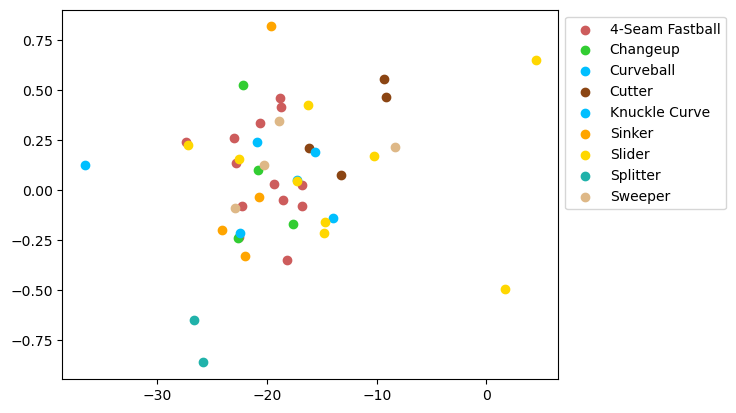

In [47]:
import json
pitch_colors = json.load(open('/home/dcooper/rockies/RockiesAnalysis/utils/analysis/savant_pitch_colors.json', 'r'))
for pitch in np.unique(np.array([index[1] for index in pitch_movement_df.index])):
    pitch_df = pitch_movement_df.xs(str(pitch), level='Pitch')
    pitch_df = pitch_df[pitch_df['Home Usage'] >= 0.10]
    plt.scatter(pitch_df['%Change']*100, pitch_df['ΔSLG'], color=pitch_colors[pitch], label=str(pitch))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

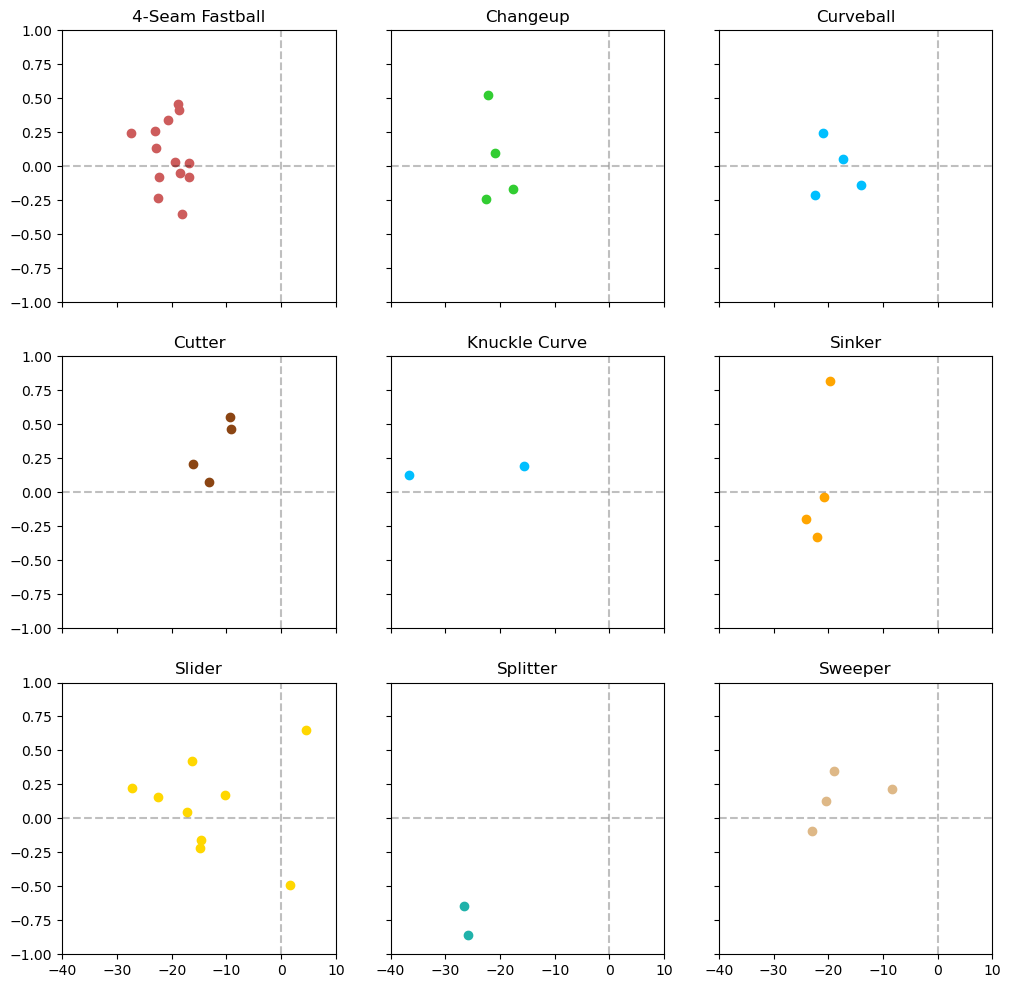

In [51]:
import json
pitch_colors = json.load(open('/home/dcooper/rockies/RockiesAnalysis/utils/analysis/savant_pitch_colors.json', 'r'))
unique_pitches = np.unique(np.array([index[1] for index in pitch_movement_df.index]))
fig, axs = plt.subplots(3,3, figsize=(12,12))
for ax, pitch in zip(axs.flatten(), unique_pitches):
    pitch_df = pitch_movement_df.xs(str(pitch), level='Pitch')
    pitch_df = pitch_df[pitch_df['Home Usage'] >= 0.10]
    ax.scatter(pitch_df['%Change']*100, pitch_df['ΔSLG'], color=pitch_colors[pitch], label=str(pitch))
    ax.set_title(pitch)
    ax.set_ylim(-1,1)
    ax.set_xlim(-40,10)
    ax.vlines(0,-1,1, color='k', linestyle='dashed', alpha=0.25)
    ax.hlines(0,-40,10, color='k', linestyle='dashed', alpha=0.25)
    ax.label_outer()

plt.show()